# Importing Packages and Downloading Dataset

In [1]:
import tensorflow as tf
import kagglehub
import pandas as pd
kagglehub.login()
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

filename = 'IMDB Dataset.csv'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DJ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Path to dataset files: C:\Users\DJ\.cache\kagglehub\datasets\lakshmi25npathi\imdb-dataset-of-50k-movie-reviews\versions\1


In [2]:
df = pd.read_csv(path + '\\' + filename)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

# Preprocessing Text

In [6]:
english_stopwords = stopwords.words('english')
print(english_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

Using the standard nltk stopword list, we notice many negative words such as no, nor, and not which can reduce the accuracy of our sentiment analysis model. For example, the sentence "This movie is not good" would be reduced to "This movie is good", which has a completely different meaning and changes the review from negative to positive. Thus, I decided to not apply stopworld removal, especially because my approach is using a RNN with LSTM and the model can gain additional context leaving those stopwords in.

I also built the model without lemmatized text and with lemmatized text and found the accuracy to be almost identical, so I doubt lemmatization is particularly useful for an RNN, but I left it in since this processing step only took one minute to compile.

In [7]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens) #lemmatize text
    
    text = text.lower() #convert to lowercase
    text = re.sub(r'<[^>]+>', '', text) # remove HTML tags
    text = re.sub(r'http\S+ | www\S+', '', text) # Remove links
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) #remove nonalphanumeric characters and punctuation
    
    #text = ' '.join([t for t in tokens if t not in english_stopwords]) #remove stopwords
    return text

In [8]:
df['review'] = df['review'].apply(preprocess_text)
df.head()

,review,sentiment
0,one of the other reviewer ha mentioned that af...,positive
1,a wonderful little production the filming t...,positive
2,i thought this wa a wonderful way to spend tim...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is...,positive


In [9]:
for sentence in df['review'].head(100):
    words = sentence.split()
    print(len(words))


314
158
167
135
228
123
155
177
127
32
93
179
403
113
51
143
147
222
129
138
314
180
68
326
152
113
576
143
125
615
407
349
104
655
261
373
98
308
120
268
121
212
174
260
183
231
79
145
703
99
419
625
165
83
199
207
212
172
493
445
171
151
82
48
183
293
334
144
211
295
226
281
246
190
275
157
308
621
138
292
165
151
260
430
74
150
299
144
191
353
169
193
394
174
145
267
191
136
189
526


We can see from a quick sampling that most reviews fall under 500 words with some particularly lengthy reviews going above that, so I decided to use a padding size of 1024 to capture the dataset. Leaving it to default (the length of the longest review) would work fine as well but perhaps increase time needed to build the sequences.

In [10]:
# tokenize and pad the reviews for RNN processing
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])
padded_sequences = pad_sequences(sequences, 1024) #1000 would capture most of the reviews for padding, 1024 for power of 2

In [11]:
# change positive/negative to 1/0 for easier processing in RNN
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# split data for train/test from tensorflow. X = word reviews and Y = 1/0 for positive/negative review.
X = padded_sequences
y = df['sentiment'].values

# Building the LSTM RNN

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #80% training data, 20% test data.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 128), #recommended embedding dimension size is 100 to 300 for NLP
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]) #embedding layer, two LSTM layers, and two dense layers for NLP. 2-3 LSTM layers recommended for this type of problem.

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# early stopping callback. used to automatically determine a good number of epochs for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train,
                    epochs=150,
                    batch_size=5,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=0)

I first decided to use two LSTM layers with a 64 hidden unit layer feeding into a 32 hidden unit layer and was satisfied with the accuracy. If I wanted to optimize the accuracy even further, I could tune the hyperparameters by changing the number of hidden units, changing the number of LSTM layers, or changing the dense layers and test what parameters would give me the best results.

I also used early stopping to best choose the number of epochs to avoid overfitting. More epochs would most likely reduce validation accuracy while training accuracy continued to improve (overfitting), while less epochs would reduce training accuracy and make the model too simple to deal with certain types of reviews (underfitting).

# Accuracy and Sample Reviews

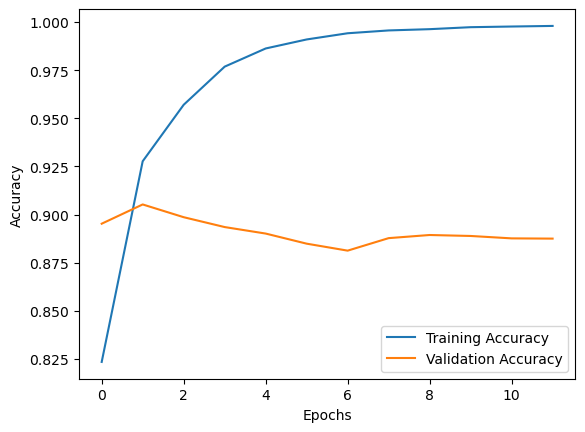

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.2f}")
print(f'Test Accuracy: {test_accuracy:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 116ms/step - accuracy: 0.9099 - loss: 0.2413
Test Loss: 0.24
Test Accuracy: 0.91


In [16]:
sample_reviews = [
    "This movie was great! The plot was thrilling and kept me engaged the entire time.",
    "The film was terrible, I don't even know what happened after two hours",
    "It wasn't bad but definitely not great. There were some good scenes but it dragged on pretty long. Overall a 4/10.",
    "The movie was pretty decent. I liked the ending."
]

sample_sequences = tokenizer.texts_to_sequences(sample_reviews)
sample_padded = pad_sequences(sample_sequences, 1024)

predictions = model.predict(sample_padded)
print(["Positive" if prob > 0.5 else "Negative" for prob in predictions])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
['Positive', 'Negative', 'Negative', 'Positive']
